## Importing Dependencies and Initializing Parameters

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
data_dir = '/kaggle/input/Real_Life_Violence_Dataset'
CLASS_LIST = ['Violence','NonViolence']
seed = 42
img_height, img_width = 100, 100
batch_size = 8
SEQUENCE_LENGTH = 16

## Preprocessing

In [8]:
def extract_frames(video_path):

    frames = []
    video_reader = cv2.VideoCapture(video_path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames//SEQUENCE_LENGTH,1)

    for i in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)

        ret,frame = video_reader.read()
        if not ret:
            break

        resized_frame = cv2.resize(frame,(img_height,img_width))

        normalized_frame = resized_frame / 255.0

        frames.append(normalized_frame)

    video_reader.release()

    return frames

def create_dataset(max_vid_per_class = 750):

    features = []
    labels = []


    for class_index,class_name in enumerate(CLASS_LIST):

        print(f"Extracting Data of Class:{class_name}")

        files_list = os.listdir(os.path.join(data_dir,class_name))

        count = 0
        for filename in files_list:
            if count >= max_vid_per_class:
                break

            video_path = os.path.join(data_dir,class_name,filename)
            frames = extract_frames(video_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                count += 1

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [9]:
features,labels = create_dataset()

Extracting Data of Class:Violence
Extracting Data of Class:NonViolence


[h264 @ 0xa754f600] mb_type 104 in P slice too large at 98 31
[h264 @ 0xa754f600] error while decoding MB 98 31
[h264 @ 0xa754f600] mb_type 104 in P slice too large at 98 31
[h264 @ 0xa754f600] error while decoding MB 98 31
[h264 @ 0xa754f600] mb_type 104 in P slice too large at 98 31
[h264 @ 0xa754f600] error while decoding MB 98 31
[h264 @ 0xa754f600] mb_type 104 in P slice too large at 98 31
[h264 @ 0xa754f600] error while decoding MB 98 31


In [10]:
features_temp,features_test,labels_temp,labels_test = train_test_split(features,labels,
                                                                        test_size=0.1,
                                                                        random_state=seed)

In [11]:
features_train,features_val,labels_train,labels_val = train_test_split(features_temp,labels_temp,
                                                                        test_size=0.2,
                                                                        random_state=seed)

In [12]:
ohc_labels_train = to_categorical(labels_train)
ohc_labels_val = to_categorical(labels_val)
ohc_labels_test = to_categorical(labels_test)

## Model Building and Training

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Input(shape=(16, 100, 100, 3)))

model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())  
model.add(Dropout(0.4))  

model.add(Dense(units=256, activation='relu'))  
model.add(BatchNormalization())  
model.add(Dropout(0.4))  

model.add(Dense(units=2, activation='softmax'))  

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


I0000 00:00:1748092786.151537      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748092786.152171      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 16, 100, 100, 64)    │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 100, 100, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 8, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 8, 50, 50, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 50, 50, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 4, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 4, 25, 25, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 25, 25, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 2, 12, 12, 512)      │       3,539,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 12, 12, 512)      │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 6, 6, 512)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,227,458 (54.27 MB)

 Trainable params: 14,224,002 (54.26 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [14]:
# Reduce learning rate when validation accuracy plateaus
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint1 = ModelCheckpoint(
    filepath='best3dcnn_model.weights.h5',   
    monitor='val_accuracy',     
    save_best_only=True,        
    save_weights_only=True,
    mode='max',                 
    verbose=1                   
)

checkpoint2 = ModelCheckpoint(
    filepath='best3dcnn_model.keras',   
    monitor='val_accuracy',     
    save_best_only=True,        
    save_weights_only=False,
    mode='max',                 
    verbose=1                   
)


early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=15,             
    restore_best_weights=True,  
    mode='min'              
)

In [16]:
history = model.fit(features_train, ohc_labels_train, 
                    epochs=50, batch_size=8, 
                    validation_data=(features_val, ohc_labels_val), 
                    callbacks=[early_stopping, checkpoint1, checkpoint2, reduce_lr])

Epoch 1/50


I0000 00:00:1748092803.314097    6105 service.cc:148] XLA service 0x7acc38008bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748092803.316296    6105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748092803.316323    6105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748092804.320808    6105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748092814.793579    6105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5921 - loss: 0.9031
Epoch 1: val_accuracy improved from -inf to 0.44815, saving model to best3dcnn_model.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.44815, saving model to best3dcnn_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 228ms/step - accuracy: 0.5925 - loss: 0.9022 - val_accuracy: 0.4481 - val_loss: 4.5013 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7016 - loss: 0.6670
Epoch 2: val_accuracy improved from 0.44815 to 0.65185, saving model to best3dcnn_model.weights.h5

Epoch 2: val_accuracy improved from 0.44815 to 0.65185, saving model to best3dcnn_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - accuracy: 0.7016 - loss: 0.6669 - val_accuracy: 0.6519 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6922 - loss: 0.6561
Epoch 3: val_accuracy did not improve from 0.65185

Epoch 3: val_accuracy did

In [17]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

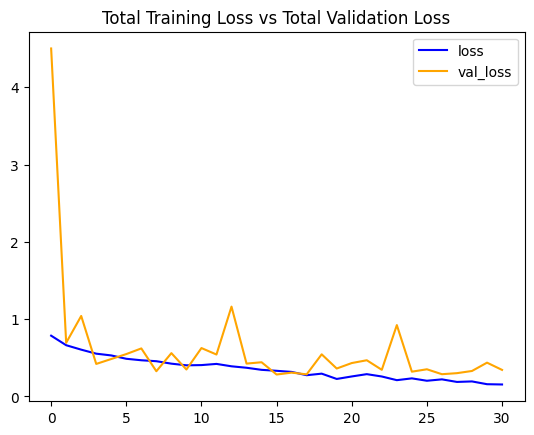

In [18]:
plot_metric(history, 'loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

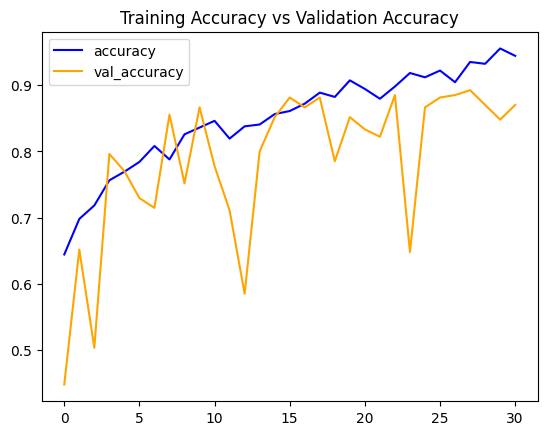

In [19]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy')

## Testing

In [20]:
import time

In [21]:
start_time = time.perf_counter()
loss, accuracy = model.evaluate(features_test, ohc_labels_test)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 995ms/step - accuracy: 0.8470 - loss: 0.3191
Elapsed time: 8.978010 seconds
Test Loss: 0.2638567090034485
Test Accuracy: 0.8666666746139526


In [22]:
labels_predict = model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(ohc_labels_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step


In [23]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8666666666666667


### Confusion Matrix Representation

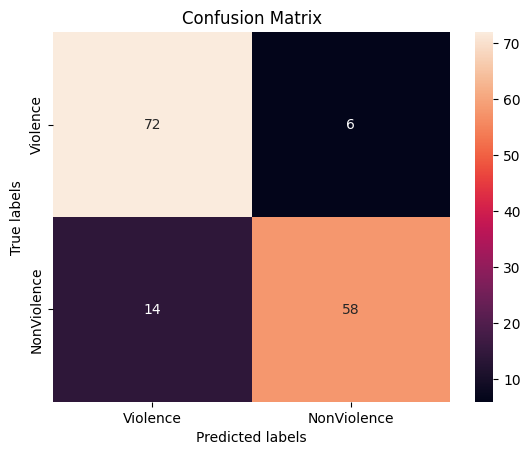

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Violence', 'NonViolence'])
ax.yaxis.set_ticklabels(['Violence', 'NonViolence'])

plt.savefig('/kaggle/working/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()